In [141]:
import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import pairwise_distances
import re
import seaborn as sns


In [142]:
books_df = pd.read_csv("./data/Books.csv")
users_df = pd.read_csv("./data/Users.csv")
ratings_df = pd.read_csv("./data/ratings.csv")

C:\Users\NelsonWang\AppData\Local\Temp\ipykernel_25068\2335125731.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books_df = pd.read_csv("./data/Books.csv")


In [143]:
books_df.info()
users_df.info()
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271359 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)

In [144]:
#  0   ISBN                 271360 non-null  object
#  1   Book-Title           271360 non-null  object
#  2   Book-Author          271359 non-null  object
#  3   Year-Of-Publication  271360 non-null  object
#  4   Publisher            271358 non-null  object
#  5   Image-URL-S          271360 non-null  object
#  6   Image-URL-M          271360 non-null  object
#  7   Image-URL-L          271357 non-null  object

ISBN = 'ISBN'
BOOK_TITLE = 'Book-Title'
BOOK_AUTHOR = 'Book-Author'
YEAR_OF_PUBLICATION = 'Year-Of-Publication'
PUBLISHER = 'Publisher'
IMAGE_URL_S = 'Image-URL-S'
IMAGE_URL_M = 'Image-URL-M'
IMAGE_URL_L = 'Image-URL-L'

#  #   Column    Non-Null Count   Dtype  
# ---  ------    --------------   -----  
#  0   User-ID   278858 non-null  int64  
#  1   Location  278858 non-null  object 
#  2   Age       168096 non-null  float64

USER_ID = 'User-ID'
LOCATION = 'Location'
AGE = 'Age'

# 0   User-ID        1149780 non-null  int64
#  1   ISBN         1149780 non-null  object
#  2   Book-Rating  1149780 non-null  int64 

BOOK_RATING = 'Book-Rating'


## Exploratory Questions

1) Whats the maximum amount of Book ratings provided by na user?
2) How many users with no ratings or just 1?
3) How many books have no ratings?
4) Does books with higher ratings also have more ratings?



In [145]:

# Whats the maximum amounf of book ratings per user?
# Group by User-ID

ratings_per_user = ratings_df.groupby(USER_ID)[ISBN].count()
ratings_per_user.describe()
ratings_per_user.info()

<class 'pandas.core.series.Series'>
Int64Index: 105283 entries, 2 to 278854
Series name: ISBN
Non-Null Count   Dtype
--------------   -----
105283 non-null  int64
dtypes: int64(1)
memory usage: 1.6 MB


Min ratings per user: 1
Max ratings per user: 13602


User-ID
2          1
7          1
8         18
9          3
10         2
          ..
278846     2
278849     4
278851    23
278852     1
278854     8
Name: ISBN, Length: 105283, dtype: int64

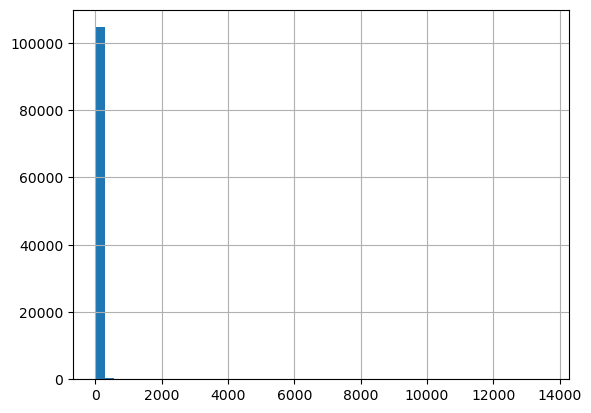

In [146]:

min_ratings_per_user = ratings_per_user.min()
print(f"Min ratings per user: {min_ratings_per_user}")

max_ratings_per_user = ratings_per_user.max()
print(f"Max ratings per user: {max_ratings_per_user}")

# Lets see the distribution of ratings per user on a bar chart distribution
ratings_per_user.hist(bins=50)
ratings_per_user


<AxesSubplot:>

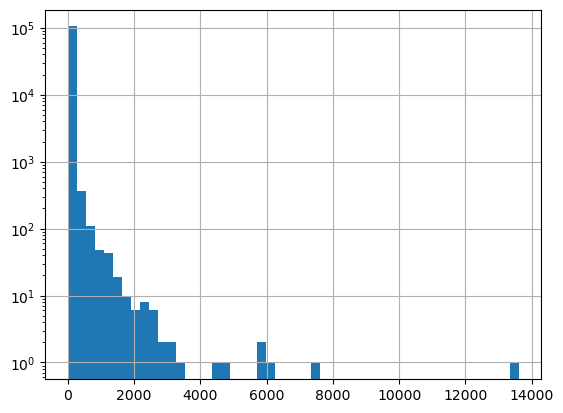

In [147]:
# Lets explore in a logaritmic scale
ratings_per_user.hist(bins=50, log=True)

In [148]:
# Lets remove all where user has rated less than equal to 1 book in the in the transaction df.

# First lets identify the users that have rated less than 2 books
users_to_remove = ratings_per_user[ratings_per_user <= 2].index

# Now lets remove the users from the ratings df
ratings_df = ratings_df[~ratings_df[USER_ID].isin(users_to_remove)]
ratings_df.head()

,User-ID,ISBN,Book-Rating
10,276746,0425115801,0
11,276746,0449006522,0
12,276746,0553561618,0
13,276746,055356451X,0
14,276746,0786013990,0


In [149]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1065610 entries, 10 to 1149775
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1065610 non-null  int64 
 1   ISBN         1065610 non-null  object
 2   Book-Rating  1065610 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 32.5+ MB


In [150]:
# Is there a correlation between count of books rated and the average rating?
ratings_per_user_df = pd.DataFrame(ratings_per_user)
ratings_per_user_df.columns = ['count']
ratings_per_user_df['average_rating'] = ratings_df.groupby(USER_ID)[BOOK_RATING].mean()
correlation = ratings_per_user_df['average_rating'].corr(ratings_per_user_df['count'])
print(f"Correlation between count of books rated and the average rating: {correlation}")
ratings_per_user_df.info()

Correlation between count of books rated and the average rating: -0.10361077289901927
<class 'pandas.core.frame.DataFrame'>
Int64Index: 105283 entries, 2 to 278854
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   count           105283 non-null  int64  
 1   average_rating  33615 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 2.4 MB


In [151]:
# Remove non-null
ratings_per_user_df = ratings_per_user_df.dropna()
ratings_per_user_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33615 entries, 8 to 278854
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   count           33615 non-null  int64  
 1   average_rating  33615 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 787.9 KB


Text(0.5, 1.0, 'Correlation between count of books rated and average rating')

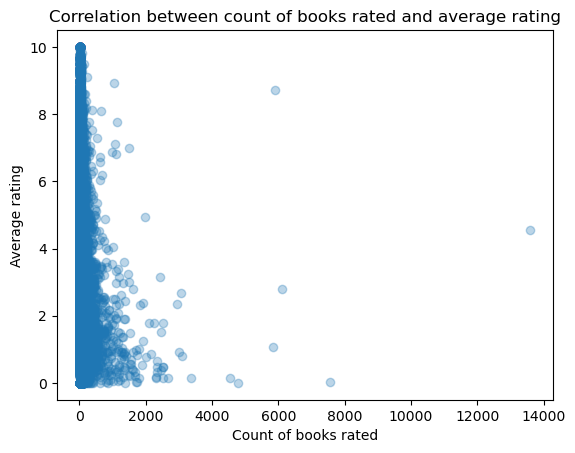

In [152]:
# Lets plot the correlation
plt.scatter(ratings_per_user_df['count'], ratings_per_user_df['average_rating'], alpha=0.3)
plt.xlabel('Count of books rated')
plt.ylabel('Average rating')
plt.title('Correlation between count of books rated and average rating')

In [153]:
# Is it even humanly possible to rate more than 1000 books? What would the correlation look like for those with less than 2000 books rated?

ratings_per_user_df_less_2000 = ratings_per_user_df[ratings_per_user_df['count'] < 2000]
ratings_per_user_df_less_2000['average_rating'].corr(ratings_per_user_df_less_2000['count'])


-0.1416672483292712

Text(0.5, 1.0, 'Correlation between count of books rated and average rating (less than 2000 books rated)')

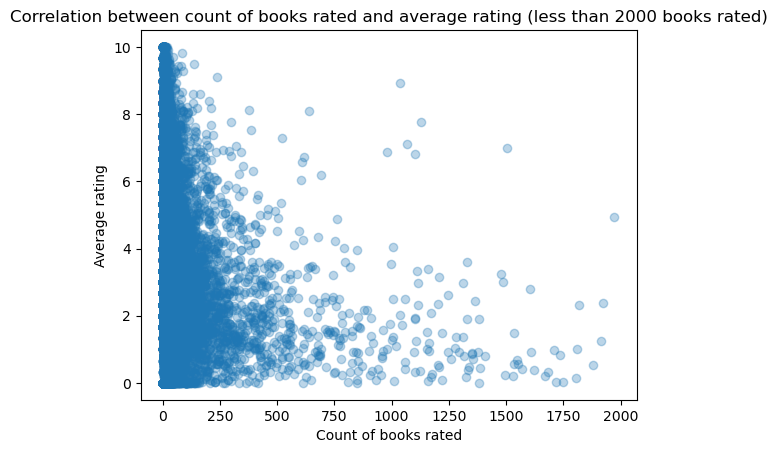

In [154]:
# Lets plot that
plt.scatter(ratings_per_user_df_less_2000['count'], ratings_per_user_df_less_2000['average_rating'], alpha=0.3)
plt.xlabel('Count of books rated')
plt.ylabel('Average rating')
plt.title('Correlation between count of books rated and average rating (less than 2000 books rated)')

In [155]:
# Lets chekc the P-value
from scipy.stats import pearsonr
correlation, p_value = pearsonr(ratings_per_user_df_less_2000['count'], ratings_per_user_df_less_2000['average_rating'])
print(f"Correlation: {correlation}")
# Format the p-value to 5 decimal places
print(f"P-value: {p_value:.5f}")



Correlation: -0.14166724832927113
P-value: 0.00000



### Hypothesis Explaitnations to this trend:

1. The more books one consumes the more critic he becomes of the book he reads.
2. Readers with high count of books rated are professional critics, thus higher standards.
3. Trolling downvote bombing and defaation attempts to make their own books more popular. ^1 ^2


^1: [The Latest Goodreads Review Bombing Scandal](https://critteranne.medium.com/the-latest-goodreads-review-bombing-scandal-0835c9002b75)
^2: [Sci-fi writer who got caught review-bombing her rival authors fesses up, loses book deal](https://www.businessinsider.com/author-review-bombing-scandal-apology-loses-book-deal-publisher-booktok-2023-12#:~:text=An%20investigation%20that%20began%20on,fake%20accounts%2C%20her%20fellow%20authors.)




In [156]:
# How many books have only one a single user rating?

grouped_books_by_ISBN = ratings_df.groupby(ISBN)[USER_ID]
# Show grouped_books_by_ISBN.count()
print(grouped_books_by_ISBN.count())
# Total count of books?
total_books = grouped_books_by_ISBN.count()
print(f"Total books: {len(total_books)}")


# Lets see the distribution of books with only one ratings_count
 # What are the books with only one rating?
books_with_only_one_rating = grouped_books_by_ISBN.count()[grouped_books_by_ISBN.count() == 1]
books_with_only_one_rating.head()

# Percentage of books with only one rating
percentage_books_with_only_one_rating = len(books_with_only_one_rating) / len(total_books)
print(f"Percentage of books with only one rating: {percentage_books_with_only_one_rating}")


ISBN
 0330299891    1
 0375404120    2
 0586045007    1
 9022906116    2
 9032803328    1
              ..
cn113107       1
ooo7156103     1
§423350229     1
´3499128624    1
Ô½crosoft      1
Name: User-ID, Length: 326306, dtype: int64
Total books: 326306
Percentage of books with only one rating: 0.5886560467781775


count    326306.000000
mean          3.265677
std          11.224194
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max        1851.000000
Name: User-ID, dtype: float64

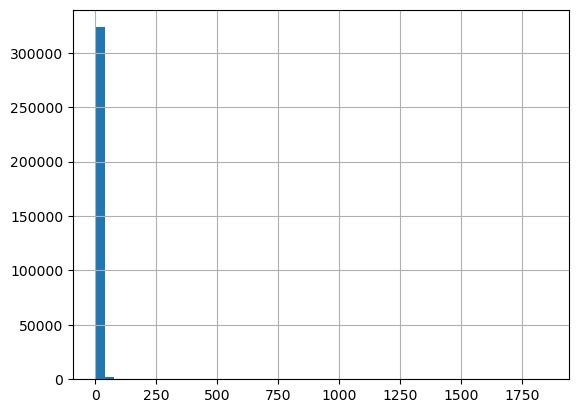

In [157]:
# Exploring the distribution of book ratings count per book

grouped_books_by_ISBN = ratings_df.groupby(ISBN)[USER_ID]
books_ratings_count = grouped_books_by_ISBN.count()
books_ratings_count.hist(bins=50)
books_ratings_count.describe()



<AxesSubplot:>

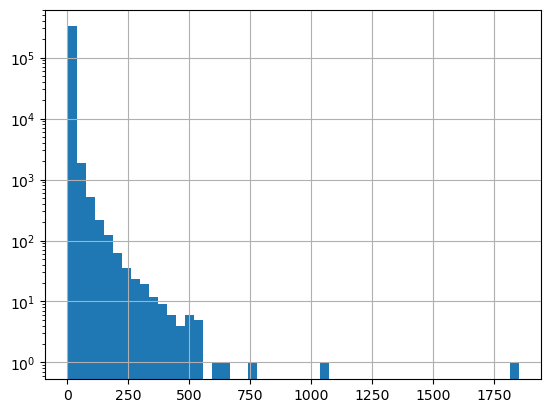

In [158]:


# Logarithmic scale?
books_ratings_count.hist(bins=50, log=True)


count    134224.000000
mean          6.507987
std          16.982731
min           2.000000
25%           2.000000
50%           3.000000
75%           5.000000
max        1851.000000
Name: User-ID, dtype: float64

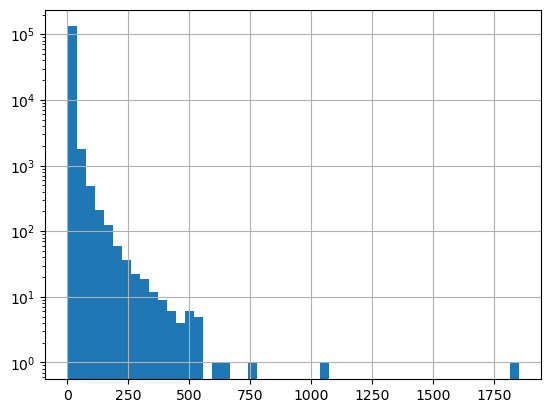

In [159]:
# # Exploring the distribution of book ratings count per book after removing books with only one rating

books_ratings_count_more_than_one = books_ratings_count[books_ratings_count > 1]
books_ratings_count_more_than_one.hist(bins=50, log=True)
books_ratings_count_more_than_one.describe()

Books count after removing books with less than 5 ratings: 32471


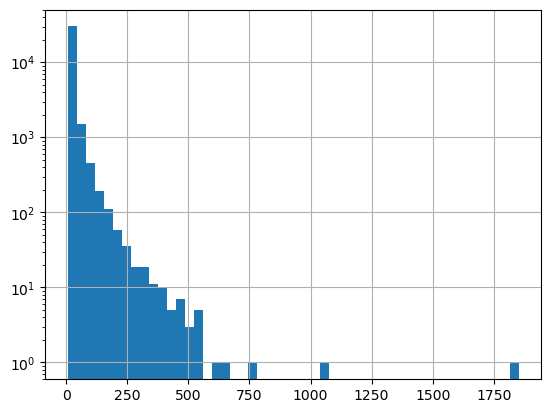

In [160]:
# # Exploring the distribution of book ratings count per book after removing books with less than 5 ratings.

books_ratings_count_more_than_five = books_ratings_count[books_ratings_count > 5]
books_ratings_count_more_than_five.hist(bins=50, log=True)
books_ratings_count_more_than_five.describe()
# print of books count after removing books with less than 5 ratings
print(f"Books count after removing books with less than 5 ratings: {len(books_ratings_count_more_than_five)}")


             count  average_rating
ISBN                              
 0330299891      1             0.0
 0375404120      2             1.5
 0586045007      1             0.0
 9022906116      2             3.5
 9032803328      1             0.0
Correlation between count of books rated and the average rating: -0.008053419221361999
Correlation: -0.008053419221361975
P-value: 0.00000


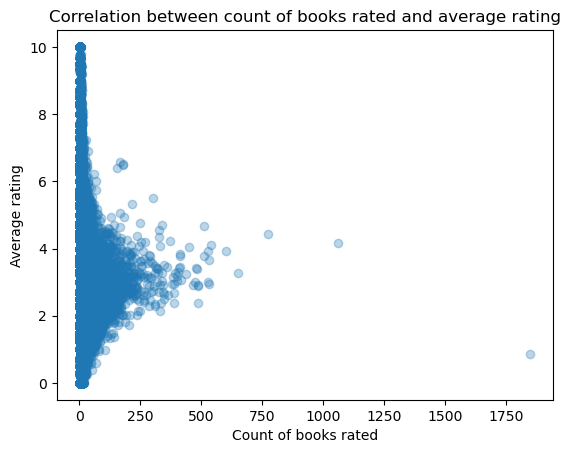

In [161]:
# Are the books with more count of ratings also rated higher?

books_ratings_count_df = pd.DataFrame(books_ratings_count)
books_ratings_count_df.columns = ['count']
books_ratings_count_df['average_rating'] = ratings_df.groupby(ISBN)[BOOK_RATING].mean()

print(books_ratings_count_df.head())

correlation = books_ratings_count_df['average_rating'].corr(books_ratings_count_df['count'])
print(f"Correlation between count of books rated and the average rating: {correlation}")

# Lets plot the correlation
# Reduce opacity
plt.scatter(books_ratings_count_df['count'], books_ratings_count_df['average_rating'], alpha=0.3)
plt.xlabel('Count of books rated')
plt.ylabel('Average rating')
plt.title('Correlation between count of books rated and average rating')

# Lets check the P-value
correlation, p_value = pearsonr(books_ratings_count_df['count'], books_ratings_count_df['average_rating'])
print(f"Correlation: {correlation}")
print(f"P-value: {p_value:.5f}")


               count  average_rating
ISBN                                
0 907 062 008      8        3.750000
00000000           6        2.666667
000000000         13        0.461538
0000000000         8        4.125000
0002005018        13        4.615385
Correlation between count of books rated and the average rating for books with more than 5 ratings: 0.05178447604328721
Correlation: 0.0517844760432872
P-value: 0.00000


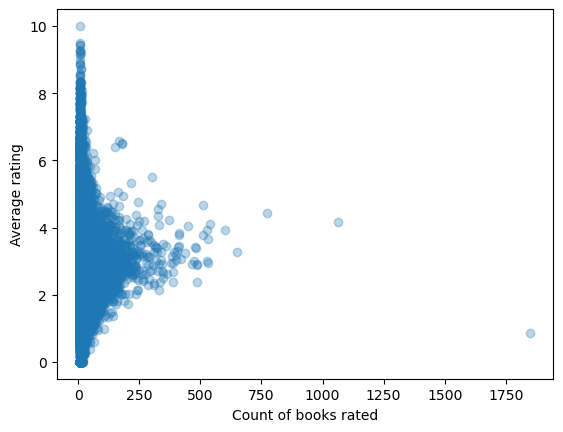

In [162]:
# Lets see this for books with more than 5 ratings
books_ratings_count_df_more_than_five = books_ratings_count_df[books_ratings_count_df['count'] > 5]
books_ratings_count_df_more_than_five.describe()
print(books_ratings_count_df_more_than_five.head())
correlation = books_ratings_count_df_more_than_five['average_rating'].corr(books_ratings_count_df_more_than_five['count'])
print(f"Correlation between count of books rated and the average rating for books with more than 5 ratings: {correlation}")

# Lets plot the correlation
plt.scatter(books_ratings_count_df_more_than_five['count'], books_ratings_count_df_more_than_five['average_rating'], alpha=0.3)
plt.xlabel('Count of books rated')
plt.ylabel('Average rating')

# Lets check the P-value
correlation, p_value = pearsonr(books_ratings_count_df_more_than_five['count'], books_ratings_count_df_more_than_five['average_rating'])
print(f"Correlation: {correlation}")
print(f"P-value: {p_value:.5f}")

Text(0.5, 1.0, 'Correlation between count of books rated and average rating for books with more than 5 ratings (Logarithmic)')

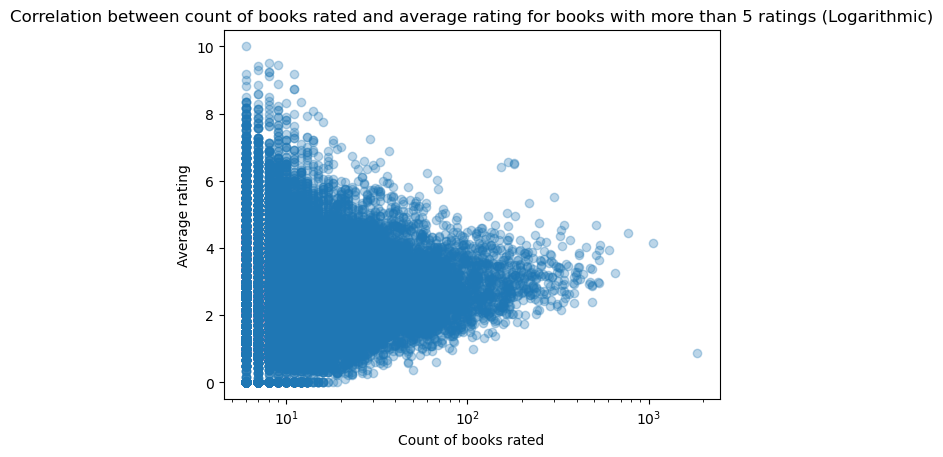

In [163]:
# Logartihmic on the x axis
plt.scatter(books_ratings_count_df_more_than_five['count'], books_ratings_count_df_more_than_five['average_rating'], alpha=0.3)
plt.xlabel('Count of books rated')
plt.ylabel('Average rating')
plt.xscale('log')
plt.title('Correlation between count of books rated and average rating for books with more than 5 ratings (Logarithmic)')

In [164]:
# What was the mean rating of all books again?
mean_rating = ratings_df[BOOK_RATING].mean()
print(f"Mean rating of all books: {mean_rating}")

Mean rating of all books: 2.732392714032338


# More fun, trying to find segments of people.

1) Group by the amount of ratings given by a user, and see the average rating given by that group. Then plot on scatter plot


Text(0, 0.5, 'Average rating Per Group')

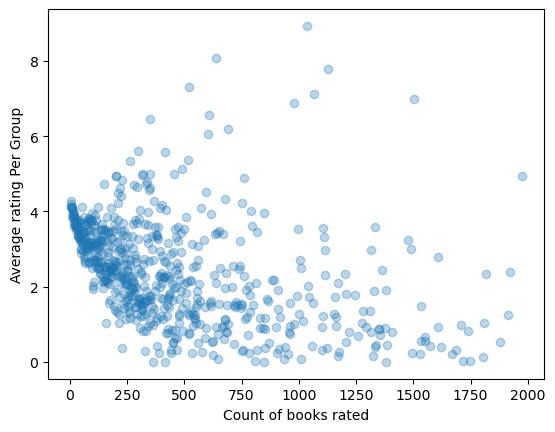

In [165]:
# Group by the amount of ratings given by a user, and see the average rating given by that group. Then plot on scatter plot
ratings_per_user_df = pd.DataFrame(ratings_per_user)
ratings_per_user_df.columns = ['count']
ratings_per_user_df['average_rating'] = ratings_df.groupby(USER_ID)[BOOK_RATING].mean()
ratings_per_user_df = ratings_per_user_df.dropna()
ratings_per_user_df = ratings_per_user_df[ratings_per_user_df['count'] < 2000]
ratings_per_user_df['count'] = ratings_per_user_df['count'].astype(int)
ratings_per_user_df = ratings_per_user_df.groupby('count')['average_rating'].mean()
ratings_per_user_df = ratings_per_user_df.reset_index()

plt.scatter(ratings_per_user_df['count'], ratings_per_user_df['average_rating'], alpha=0.3)
plt.xlabel('Count of books rated')
plt.ylabel('Average rating Per Group')


In [166]:
# Lets see if the 

## Insights from the data

- The data seems right, as the the higher the count of ratings a book has. It approaches the average.
- The lower the count of ratings a book has, the deviation and spread of ratings is higher.

# Conclusions

- Have two testing Algorithms:
  - One with all users
  - One with users with no more than 200 ratings
  - One with users with no more than 500 ratings
- Removals of low rated books:
  - Removal of books with only a singular rating?
  - Removal of books with less than total 5 ratings

## Insights

- The highest raters users tend to rate books lower.
- The 58.86 % of books have less than 2 ratings. (32471 books left)
